In [ ]:
## Validate some preprocessing steps:
# In order to apply GridSearchCV on the custom preprocessing functions that I created, 
# and determine whether they have a positive impact on the LinearSVC model or not, 
# we need to transform these functions into classes. This is necessary because 
# scikit-learn's `Pipeline` requires the use of classes that implement the `fit()` 
# and `transform()` methods. By turning each preprocessing step into a class that 
# inherits from `BaseEstimator` and `TransformerMixin`, we ensure that these functions 
# are compatible with scikit-learn pipelines, which is crucial for model optimization 
# using GridSarchCV.


In [57]:
from sklearn.base import BaseEstimator, TransformerMixin
import re
from bs4 import BeautifulSoup
import wordninja
from langdetect import detect
from googletrans import Translator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag

stop_words = set(stopwords.words('english'))
translator = Translator()

# 1. Remove URLs and HTML
class RemoveURLHTML(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(self.remove_URL_HTML)
    
    @staticmethod
    def remove_URL_HTML(text):
        text = re.sub(r"http.\S+", '', text)
        text = re.sub(r"www.\S+", '', text)
        text = re.sub(r"pic.twitter.com\S+", '', text)
        if re.search(r'<.*?>', text):  
            text = BeautifulSoup(text, "html.parser").get_text()
        return text

# 2. Remove Tags and Split Hashtags
class RemoveTagsSplitHashtags(BaseEstimator, TransformerMixin):
    def __init__(self, keep_hashtags=True):
        self.keep_hashtags = keep_hashtags
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda text: self.remove_tags_and_split_hashtags(text))
    
    def remove_tags_and_split_hashtags(self, text):
        text = re.sub(r'@[\w]+', '', text)
        if self.keep_hashtags:
            hashtags = re.findall(r'#\w+', text)
            for hashtag in hashtags:
                split_words = ' '.join(wordninja.split(hashtag[1:]))
                text = text.replace(hashtag, split_words)
        else:
            text = re.sub(r'#\w+', '', text)
        return text

# 3. Replace Patterns with Meaning
class ReplacePatternsMeaning(BaseEstimator, TransformerMixin):
    def __init__(self, emoji_dict, replace=True):
        self.emoji_dict = emoji_dict
        self.replace = replace
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda text: self.replace_patterns_with_meaning(text))
    
    def replace_patterns_with_meaning(self, text):
        if self.replace:
            for emoji, meaning in self.emoji_dict.items():
                text = re.sub(emoji, meaning, text)
        return text

# 4. Replace Abbreviations
class ReplaceAbbreviations(BaseEstimator, TransformerMixin):
    def __init__(self, abbreviations, replace=True):
        self.abbreviations = abbreviations
        self.replace = replace
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda text: self.replace_abbreviations(text))
    
    def replace_abbreviations(self, text):
        if self.replace:
            words = text.split()
            replaced_words = [self.abbreviations.get(word.lower(), word) for word in words]
            return " ".join(replaced_words)
        return text

# 5. Preprocess Text
class PreprocessText(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(self.preprocess_text)
    
    @staticmethod
    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'\d+', ' ', text)
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return text

# 6. Translate to English
class TranslateToEnglish(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(self.translate_to_english)
    
    @staticmethod
    def translate_to_english(text):
        try:
            language = detect(text)
            if language != 'en':
                return translator.translate(text, src=language, dest='en').text
            return text
        except Exception as e:
            print(f"Error: {e}")
            return text

# 7. Stopwords and Lemmatization
class StopwordsLemma(BaseEstimator, TransformerMixin):
    def __init__(self, stopwords=True):
        self.stopwords = stopwords
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda text: self.stopwords_lemma(text))
    
    def stopwords_lemma(self, text):
        lemmatizer = WordNetLemmatizer()
        words = word_tokenize(text)
        tagged_words = pos_tag(words)
        lemmatized_text = []
        for word, tag in tagged_words:
            if tag.startswith('VB'):
                lemma = lemmatizer.lemmatize(word, pos='v')
            elif tag.startswith('NN'):
                lemma = lemmatizer.lemmatize(word, pos='n')
            elif tag.startswith('JJ'):
                lemma = lemmatizer.lemmatize(word, pos='a')
            elif tag.startswith('RB'):
                lemma = lemmatizer.lemmatize(word, pos='r')
            else:
                lemma = lemmatizer.lemmatize(word)
            if self.stopwords and word.lower() in stop_words:
                continue
            lemmatized_text.append(lemma)
        return " ".join(lemmatized_text)

# 8. Stopwords and Stemming
class StopwordsStem(BaseEstimator, TransformerMixin):
    def __init__(self, stopwords=True):
        self.stopwords = stopwords
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda text: self.stopwords_and_stem(text))
    
    def stopwords_and_stem(self, text):
        stemmer = PorterStemmer()
        tokens = word_tokenize(text)
        if self.stopwords:
            stemmed_tokens = [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words]
        else:
            stemmed_tokens = [stemmer.stem(word.lower()) for word in tokens]
        return " ".join(stemmed_tokens)


In [58]:
emoji_dict = {
    r':-\)': ' happy face ',
    r':\)': ' happy face ',
    r':D': ' laugh face ',
    r':-\(': ' sad face ',
    r':\(': ' sad face ',
    r':O': ' surprised face ',
    r';-\)': ' wink face ',
    r';\)': ' wink face ',
    r':P': ' playful face ',
    r':-\?': ' undecided face ',
    r':/': ' undecided face ',
    r"\b't\b": " not" # I added this to keep all the verbs with not e.g can't -> cannot
}  

abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "af" : "as fuck",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",   
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "c'mon" : "come on",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [61]:
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

,text,sentiment
0,I am taking Avadart and thought I would try Pr...,negative
1,It was with much amusement that I read Nicko M...,negative
2,Cate Blanchett rocked these stunning gold stat...,positive
3,Manturov: Russia and Iran may begin the paymen...,neutral
4,We bought some vintage jars at a thrift store ...,neutral


In [51]:
df.shape

(8000, 2)

In [39]:
from sklearn.model_selection import train_test_split, cross_validate

# Stratified split into train and test sets (80% train, 20% test)
X = df['text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=35, stratify=y
)

In [63]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np


# Define the TfidfVectorizer
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    max_df=0.5,
    min_df=1,
    ngram_range=(1, 2),
    norm='l2',
    binary=False
)

# Define the complete pipeline
pipeline = Pipeline(steps=[
    ('remove_url_html', RemoveURLHTML()),
    ('remove_tags_split_hashtags', RemoveTagsSplitHashtags(keep_hashtags=True)),
    ('replace_patterns', ReplacePatternsMeaning(emoji_dict=emoji_dict)),
    ('replace_abbreviations', ReplaceAbbreviations(abbreviations=abbreviations)),
    ('preprocess_text', PreprocessText()),
    ('stopwords_lemma', StopwordsLemma(stopwords=True)),
    ('stopwords_stem', StopwordsStem(stopwords=False)),
    ('tfidf', tfidf),  # Add TF-IDF vectorizer step
    ('svm_clf', LinearSVC(C=0.5, multi_class='ovr', dual=False))  # SVM classifier
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=35, stratify=df['sentiment'])

# Set up GridSearchCV for hyperparameter tuning
param_grid = {
    'remove_tags_split_hashtags__keep_hashtags': [True, False],
    'replace_patterns__replace': [True, False],
    'replace_abbreviations__replace': [True, False],
    'stopwords_lemma__stopwords': [True, False],
    'stopwords_stem__stopwords': [True, False],
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

# Print best parameters and results
print("Best Parameters:", grid_search.best_params_)

# Get the best model from GridSearch
best_model = grid_search.best_estimator_

# Predict on the test data
predicted_labels = best_model.predict(X_test)

# Calculate accuracy and print classification report
test_accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, predicted_labels))

Best Parameters: {'remove_tags_split_hashtags__keep_hashtags': True, 'replace_abbreviations__replace': True, 'replace_patterns__replace': True, 'stopwords_lemma__stopwords': False, 'stopwords_stem__stopwords': False}
Test Accuracy: 59.94%
Classification Report:
              precision    recall  f1-score   support

    negative       0.64      0.47      0.54       428
     neutral       0.56      0.53      0.55       559
    positive       0.61      0.75      0.67       613

    accuracy                           0.60      1600
   macro avg       0.60      0.58      0.59      1600
weighted avg       0.60      0.60      0.59      1600



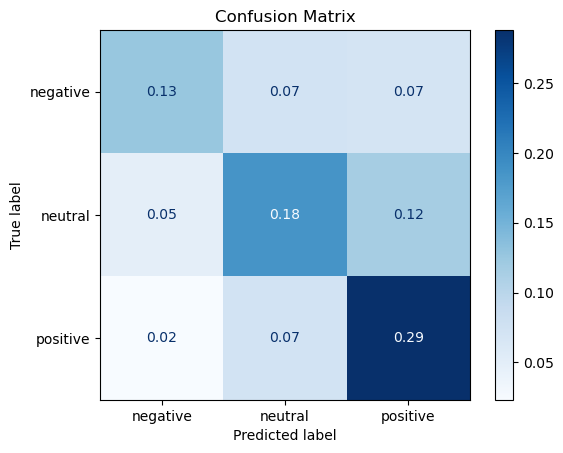

In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, predicted_labels, normalize='all')
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.classes_)
cm_display.plot(cmap='Blues', values_format='.2f') 

plt.title('Confusion Matrix')
plt.show()

\
__Lemmatizer vs Stemm__ \
I also added on this step __TranslateToEnglish__ because it required 2-3 mins and the previous grid search would be extremely time consuming.

In [106]:
from googletrans import Translator
from langdetect import detect

translator = Translator()

class TranslateToEnglish(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  
    
    def transform(self, X):
        return X.apply(self.translate_to_english)
    
    @staticmethod
    def translate_to_english(text):
        try:
            language = detect(text) 
            if language != 'en':  
                translated_text = translator.translate(text, src=language, dest='en').text
                return translated_text
            return text  
        except Exception as e:
            print(f"Error: {e}")
            return text  # Return the original text in case of error


In [109]:
pipeline = Pipeline(steps=[
    ('remove_url_html', RemoveURLHTML()),
    ('remove_tags_split_hashtags', RemoveTagsSplitHashtags(keep_hashtags=True)),
    ('replace_patterns', ReplacePatternsMeaning(emoji_dict=emoji_dict)),
    ('replace_abbreviations', ReplaceAbbreviations(abbreviations=abbreviations)),
    ('translate_to_english', TranslateToEnglish()), 
    ('preprocess_text', PreprocessText()),
    ('tfidf', tfidf), 
    ('svm_clf', LinearSVC(C=0.5, multi_class='ovr', dual=False))  
])



param_grid = {
    'remove_tags_split_hashtags__keep_hashtags': [True],
    'replace_patterns__replace': [True],
    'replace_abbreviations__replace': [True],
    'preprocess_text': [StopwordsLemma(stopwords=False), StopwordsStem(stopwords=False)], 
}

# Perform GridSearchCV with the updated pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('remove_url_html', RemoveURLHTML()),
                                       ('remove_tags_split_hashtags',
                                        RemoveTagsSplitHashtags()),
                                       ('replace_patterns',
                                        ReplacePatternsMeaning(emoji_dict={':-\\(': ' '
                                                                                    'sad '
                                                                                    'face ',
                                                                           ':-\\)': ' '
                                                                                    'happy '
                                                                                    'face ',
                                                                           ':-\\?': ' '
                                                                                    'undecided '
                                                                                    'face ',
                                                                           ':/': ' '
                                                                                 'undecided '
                                                                                 'face ',
                                                                           ':D': ' '
                                                                                 'laugh '
                                                                                 'face ',
                                                                           ':O': ' '
                                                                                 'surprised '
                                                                                 'face ',
                                                                           ':P': ' '
                                                                                 'playf...
                                       ('tfidf',
                                        TfidfVectorizer(max_df=0.5,
                                                        ngram_range=(1, 2),
                                                        sublinear_tf=True)),
                                       ('svm_clf',
                                        LinearSVC(C=0.5, dual=False))]),
             param_grid={'preprocess_text': [StopwordsLemma(stopwords=False),
                                             StopwordsStem(stopwords=False)],
                         'remove_tags_split_hashtags__keep_hashtags': [True],
                         'replace_abbreviations__replace': [True],
                         'replace_patterns__replace': [True]},
             scoring='accuracy')

In [121]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'preprocess_text': StopwordsStem(stopwords=False), 'remove_tags_split_hashtags__keep_hashtags': True, 'replace_abbreviations__replace': True, 'replace_patterns__replace': True}


In [123]:
best_model = grid_search.best_estimator_
predicted_labels = best_model.predict(X_test)


test_accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, predicted_labels))

Test Accuracy: 60.12%
Classification Report:
              precision    recall  f1-score   support

    negative       0.62      0.49      0.55       428
     neutral       0.57      0.53      0.55       559
    positive       0.61      0.75      0.68       613

    accuracy                           0.60      1600
   macro avg       0.60      0.59      0.59      1600
weighted avg       0.60      0.60      0.60      1600



In [131]:
len(predicted_labels)

1600